# Weight Sampling from PascalVOC to CVDataset


Some staffs before the Weight Sampling

In [0]:
# Downgrade tensoflow
%tensorflow_version 1.x

In [0]:
# Downgrade gast version 0.2.2
!pip install gast==0.2.2

In [0]:
# Downgrade keras version 2.2.4
!pip install keras==2.2.4

In [0]:
# Upload the gdrive
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Unzip the dataset
!unzip '/content/drive/My Drive/Dataset_CV.zip'

In [0]:
# Upload the github repo for ssd_keras
!git clone https://github.com/pierluigiferrari/ssd_keras.git

In [0]:
# Enter in ssd_keras dir
%cd /content/ssd_keras

In [0]:
# Lo usiamo per vedere se è entrato la dir di ssd_keras
!dir

## 0. Our example

Let this dataset contain annotations for the following object classes of interest:

`['person']`

That is, our dataset contains annotations for 1 object classes.

We would now like to train an SSD512 on this dataset. However, instead of going through all the trouble of training a new model from scratch, we would instead like to use the fully trained original SSD512 model that was trained on PascalVOC and fine-tune it on our dataset.

The problem is: the SSD512 that was trained on PascalVOC predicts 20 different classes, but our dataset has only 1 classes. The weight tensors of the classification layers of the PascalVOC model don't have the right shape for our model that is supposed to learn only 1 classes. Bummer.

### Sub-sample the weights that are causing problems

We could sub-sample the weights. If the weight tensors of the classification layers of the PascalVOC model don't have the right shape for our new model, we'll just **make** them have the right shape. This way we can still benefit from the pre-trained weights in those classification layers.

The great thing in this example is: PascalVOC happens to contain the one class that we care about. So when we sub-sample the weight tensors of the classification layers, we won't just do so randomly. Instead, we'll pick exactly this element from the tensor that are responsible for the classification of the 1 class that we care about.

However, even if the class in our dataset were entirely different from the classes in any of the fully trained models, it would still make a lot of sense to use the weights of the fully trained model. Any trained weights are always a better starting point for the training than random initialization, even if your model will be trained on entirely different object classes.

Let's get to it.

In [0]:
import h5py
import numpy as np
import shutil

from misc_utils.tensor_sampling_utils import sample_tensors

## 1. Load the trained weights file and make a copy

First, we'll load the HDF5 file that contains the trained weights that we need (the source file).

Then, we'll make a copy of that weights file. That copy will be our output file (the destination file).

In [0]:
# Set the path for the source weights file you want to load.

weights_source_path = '/content/drive/My Drive/weights/VGG_VOC0712_SSD_512x512_iter_120000.h5'

# Set the path and name for the destination weights file
# that you want to create.

weights_destination_path = '/content/drive/My Drive/weights/VGG_VOC0712_SSD_512x512_iter_120000_subsampled_1_class.h5'

# Make a copy of the weights file.
shutil.copy(weights_source_path, weights_destination_path)

In [0]:
# Load both the source weights file and the copy we made.
# We will load the original weights file in read-only mode so that we can't mess up anything.
weights_source_file = h5py.File(weights_source_path, 'r')
weights_destination_file = h5py.File(weights_destination_path, 'r+')

## 2. Figure out which weight tensors we need to sub-sample

Next, we need to figure out exactly which weight tensors we need to sub-sample. As mentioned above, the weights for all layers except the classification layers are fine, we don't need to change anything about those.

So which are the classification layers in SSD512? Their names are:

In [0]:
classifier_names = ['conv4_3_norm_mbox_conf',
                    'fc7_mbox_conf',
                    'conv6_2_mbox_conf',
                    'conv7_2_mbox_conf',
                    'conv8_2_mbox_conf',
                    'conv9_2_mbox_conf',
                    'conv10_2_mbox_conf']

## 3. Figure out which slices to pick

The following section is optional. I'll look at one classification layer and explain what we want to do, just for your understanding. If you don't care about that, just skip ahead to the next section.

We know which weight tensors we want to sub-sample, but we still need to decide which (or at least how many) elements of those tensors we want to keep. Let's take a look at the first of the classifier layers, "`conv4_3_norm_mbox_conf`". Its two weight tensors, the kernel and the bias, have the following shapes:

In [0]:
conv4_3_norm_mbox_conf_kernel = weights_source_file[classifier_names[0]][classifier_names[0]]['kernel:0']
conv4_3_norm_mbox_conf_bias = weights_source_file[classifier_names[0]][classifier_names[0]]['bias:0']

print("Shape of the '{}' weights:".format(classifier_names[0]))
print()
print("kernel:\t", conv4_3_norm_mbox_conf_kernel.shape)
print("bias:\t", conv4_3_norm_mbox_conf_bias.shape)

So the last axis has 84 elements. Why is that?

- PascalVOC has 20 classes, but the model also has one 'backgroud' class, so that makes 21 classes effectively.
- The 'conv4_3_norm_mbox_loc' layer predicts 4 boxes for each spatial position, so the 'conv4_3_norm_mbox_conf' layer has to predict one of the 81 classes for each of those 4 boxes.

That's why the last axis has 4 * 21 = 84 elements.

So how many elements do we want in the last axis for this layer?

Let's do the same calculation as above:

- Our dataset has 1 class, but our model will also have a 'background' class, so that makes 2 classes effectively.
- We need to predict one of those 2 classes for each of the four boxes at each spatial position.

That makes 4 * 2 = 8 elements.

Now we know that we want to keep 8 elements in the last axis and leave all other axes unchanged. But which 8 elements out of the original 84 elements do we want?

Should we just pick them randomly? If the object classes in our dataset had absolutely nothing to do with the classes in PascalVOC, then choosing those 8 elements randomly would be fine (and the next section covers this case, too). But in our particular example case, choosing these elements randomly would be a waste. Since PascalVOC happens to contain exactly the 1 class that we need, instead of sub-sampling randomly, we'll just take exactly those elements that were trained to predict our 1 class.

Here are the indices of the 1 classes in PascalVOC that we are interested in:

`[0, 15]`

The indices above represent the following classes in the PascalVOC datasets:

`['background', 'person']`

How did I find out those indices? I just looked them up in the annotations of the PascalVOC dataset.

So out of every 21 in the 84 elements, I want to pick the 2 elements above. This gives us the following 8 indices:

In [0]:
n_classes_source = 21
classes_of_interest = [0, 15]

subsampling_indices = []
for i in range(int(84/n_classes_source)):
    indices = np.array(classes_of_interest) + i * n_classes_source
    subsampling_indices.append(indices)
subsampling_indices = list(np.concatenate(subsampling_indices))

print(subsampling_indices)

These are the indices of the 8 elements that we want to pick from both the bias vector and from the last axis of the kernel tensor.

This was the detailed example for the '`conv4_3_norm_mbox_conf`' layer. And of course we haven't actually sub-sampled the weights for this layer yet, we have only figured out which elements we want to keep. The piece of code in the next section will perform the sub-sampling for all the classifier layers.

## 4. Sub-sample the classifier weights

The code in this section iterates over all the classifier layers of the source weights file and performs the following steps for each classifier layer:

1. Get the kernel and bias tensors from the source weights file.
2. Compute the sub-sampling indices for the last axis. The first three axes of the kernel remain unchanged.
3. Overwrite the corresponding kernel and bias tensors in the destination weights file with our newly created sub-sampled kernel and bias tensors.

The second step does what was explained in the previous section.

In case you want to **up-sample** the last axis rather than sub-sample it, simply set the `classes_of_interest` variable below to the length you want it to have. The added elements will be initialized either randomly or optionally with zeros. Check out the documentation of `sample_tensors()` for details.

In [0]:
# Set the number of classes in the source weights file. Note that this number must include
# the background class, so for PascalVOC's 20 classes, this must be 20 + 1 = 21.
n_classes_source = 21
# Set the indices of the classes that you want to pick for the sub-sampled weight tensors.
# In case you would like to just randomly sample a certain number of classes, you can just set
# `classes_of_interest` to an integer instead of the list below. Either way, don't forget to
# include the background class. That is, if you set an integer, and you want `n` positive classes,
# then you must set `classes_of_interest = n + 1`.
classes_of_interest = [0, 15]
# classes_of_interest = 2 # Uncomment this in case you want to just randomly sub-sample the last axis instead of providing a list of indices.

for name in classifier_names:
    # Get the trained weights for this layer from the source HDF5 weights file.
    kernel = weights_source_file[name][name]['kernel:0'].value
    bias = weights_source_file[name][name]['bias:0'].value

    # Get the shape of the kernel. We're interested in sub-sampling
    # the last dimension, 'o'.
    height, width, in_channels, out_channels = kernel.shape
    
    # Compute the indices of the elements we want to sub-sample.
    # Keep in mind that each classification predictor layer predicts multiple
    # bounding boxes for every spatial location, so we want to sub-sample
    # the relevant classes for each of these boxes.
    if isinstance(classes_of_interest, (list, tuple)):
        subsampling_indices = []
        for i in range(int(out_channels/n_classes_source)):
            indices = np.array(classes_of_interest) + i * n_classes_source
            subsampling_indices.append(indices)
        subsampling_indices = list(np.concatenate(subsampling_indices))
    elif isinstance(classes_of_interest, int):
        subsampling_indices = int(classes_of_interest * (out_channels/n_classes_source))
    else:
        raise ValueError("`classes_of_interest` must be either an integer or a list/tuple.")
    
    # Sub-sample the kernel and bias.
    # The `sample_tensors()` function used below provides extensive
    # documentation, so don't hesitate to read it if you want to know
    # what exactly is going on here.
    new_kernel, new_bias = sample_tensors(weights_list=[kernel, bias],
                                          sampling_instructions=[height, width, in_channels, subsampling_indices],
                                          axes=[[3]], # The one bias dimension corresponds to the last kernel dimension.
                                          init=['gaussian', 'zeros'],
                                          mean=0.0,
                                          stddev=0.005)
    
    # Delete the old weights from the destination file.
    del weights_destination_file[name][name]['kernel:0']
    del weights_destination_file[name][name]['bias:0']
    # Create new datasets for the sub-sampled weights.
    weights_destination_file[name][name].create_dataset(name='kernel:0', data=new_kernel)
    weights_destination_file[name][name].create_dataset(name='bias:0', data=new_bias)

# Make sure all data is written to our output file before this sub-routine exits.
weights_destination_file.flush()

That's it, we're done.

Let's just quickly inspect the shapes of the weights of the '`conv4_3_norm_mbox_conf`' layer in the destination weights file:

In [0]:
conv4_3_norm_mbox_conf_kernel = weights_destination_file[classifier_names[0]][classifier_names[0]]['kernel:0']
conv4_3_norm_mbox_conf_bias = weights_destination_file[classifier_names[0]][classifier_names[0]]['bias:0']

print("Shape of the '{}' weights:".format(classifier_names[0]))
print()
print("kernel:\t", conv4_3_norm_mbox_conf_kernel.shape)
print("bias:\t", conv4_3_norm_mbox_conf_bias.shape)

Nice! Exactly what we wanted, 8 elements in the last axis. Now the weights are compatible with our new SSD512 model that predicts 1 positive classes.

This is the end of the relevant part of this tutorial, but we can do one more thing and verify that the sub-sampled weights actually work. Let's do that in the next section.

## 5. Verify that our sub-sampled weights actually work

In our example case above we sub-sampled the fully trained weights of the SSD512 model trained on PascalVOC from 20 classes to just the 1 class that we needed.

We can now create a new SSD512 with 1 class, load our sub-sampled weights into it, and see how the model performs on a few test images that contain objects for some of this 1 class. Let's do it.

In [0]:
from keras.optimizers import Adam
from keras import backend as K
from keras.models import load_model

from models.keras_ssd512 import ssd_512
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_patch_sampling_ops import RandomMaxCropFixedAR
from data_generator.object_detection_2d_geometric_ops import Resize

### 5.1. Set the parameters for the model.

As always, set the parameters for the model. We're going to set the configuration for the SSD512.

In [0]:
img_height = 512 # Height of the input images
img_width = 512 # Width of the input images
img_channels = 3 # Number of color channels of the input images
subtract_mean = [123, 117, 104] # The per-channel mean of the images in the dataset
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we should set this to `True`, but weirdly the results are better without swapping.
# TODO: Set the number of classes.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales = [0.07, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05] # The anchor box scaling factors used in the original SSD512.
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0], 
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD512; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 128, 256, 512] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are scaled as in the original implementation
normalize_coords = True

### 5.2. Build the model

Build the model and load our newly created, sub-sampled weights into it.

In [0]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_512(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='inference',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=subtract_mean,
                divide_by_stddev=None,
                swap_channels=swap_channels,
                confidence_thresh=0.5,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400,
                return_predictor_sizes=False)

print("Model built.")

# 2: Load the sub-sampled weights into the model.

# Load the weights that we've just created via sub-sampling.
weights_path = weights_destination_path

model.load_weights(weights_path, by_name=True)

print("Weights file loaded:", weights_path)

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

### 5.3. Load some images to test our model on

We sub-sampled person category from the trained SSD512 PascalVOC weights, so let's try out our model on a few person images. Let's instantiate a `DataGenerator` and load the CV dataset. Everything here is preset already, but if you'd like to learn more about the data generator and its capabilities, take a look at the detailed tutorial in [this](https://github.com/pierluigiferrari/data_generator_object_detection_2d) repository.

In [0]:
dataset = DataGenerator()

# Set the paths to our dataset here.
images_path = '/content/Dataset_CV/ImagesDir/'
labels_path = '/content/Dataset_CV/AnnotationsDir/'
test_path   = '/content/Dataset_CV/ImageSet/test.txt'

dataset.parse_xml(images_dirs=[images_path],
                  image_set_filenames=[test_path],
                  annotations_dirs=[labels_path],
                  classes=['background', 'person'],
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False)

print("Number of images in the dataset:", dataset.get_dataset_size())

Make sure the batch generator generates images of size `(512, 512)`. We'll first randomly crop the largest possible patch with aspect ratio 1.0 and then resize to `(512, 512)`.

In [0]:
convert_to_3_channels = ConvertTo3Channels()
random_max_crop = RandomMaxCropFixedAR(patch_aspect_ratio=img_width/img_height)
resize = Resize(height=img_height, width=img_width)

generator = dataset.generate(batch_size=1,
                             shuffle=True,
                             transformations=[convert_to_3_channels,
                                              random_max_crop,
                                              resize],
                             returns={'processed_images',
                                      'processed_labels',
                                      'filenames'},
                             keep_images_without_gt=False)

In [0]:
# Generate samples

batch_images, batch_labels, batch_filenames = next(generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(batch_labels[i])

### 5.4. Make predictions and visualize them

In [0]:
# Make a prediction

y_pred = model.predict(batch_images)

In [0]:
# Decode the raw prediction.

i = 0

confidence_threshold = 0.5

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('    class    conf  xmin    ymin    xmax    ymax')
print(y_pred_thresh[i])

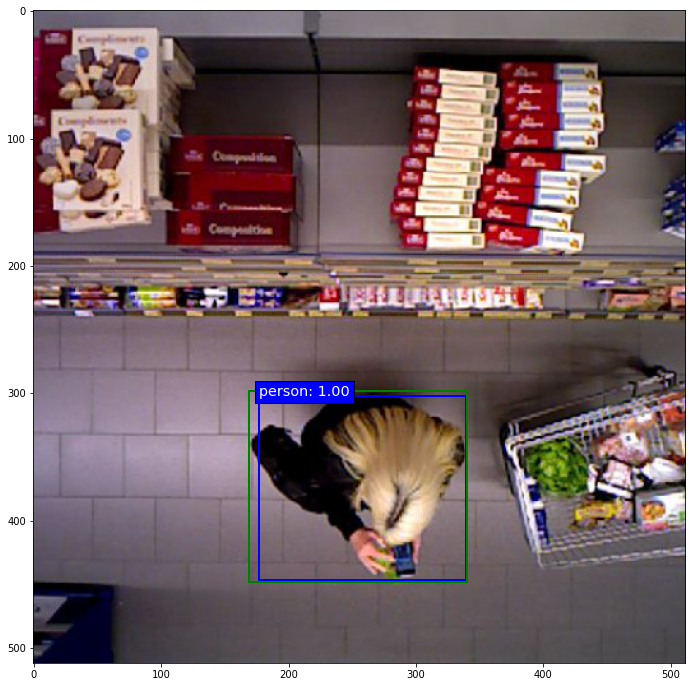

In [0]:
# Visualize the predictions.

from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(20,12))
plt.imshow(batch_images[i])

current_axis = plt.gca()

classes = ['background', 'person'] # Just so we can print class names onto the image instead of IDs

# Draw the predicted boxes in blue
for box in y_pred_thresh[i]:
    class_id = box[0]    
    confidence = box[1]
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    label = '{}: {:.2f}'.format(classes[int(class_id)], confidence)
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='blue', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'blue', 'alpha':1.0})

# Draw the ground truth boxes in green (omit the label for more clarity)
for box in batch_labels[i]:
    class_id = box[0]
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(class_id)])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    #current_axis.text(box[1], box[3], label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

Seems as if our sub-sampled weights were doing a good job, sweet. Now we can fine-tune this model on our dataset with 1 class.